# **CLUSTERING MODELS**

This kernel consists of three objectives:
1. Perform exploratory analysis  to extract meaningful insight from the data and identify the best features to be used for  modeling.  

2. Train, test, and refine various clustering models in order to create more explainable people groups. The predictive algorithms to be trained are:
    - K Means
    - Hierarchical
    - DBSCAN
    - HDBSCAN
    - GMM (Gaussian Mixture Models)

### **TRAINING DATA PRE-PROCESSING** 
The first step in the machine learning pipeline is to clean and transform the training data into a useable format for analysis and modeling.   

As such, data pre-processing addresses:
- Assumptions about data shape
- Incorrect data types
- Outliers or errors
- Missing values
- Categorical variables 

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
%matplotlib inline
import sklearn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10,5]

In [3]:
# Read data
train_data = pd.read_csv('../data/data.csv')

**Data Shape**  
After loading the dataset, I examine its shape to get a better sense of the data and the information it contains.  

In [4]:
# Data shape
print('train data:',train_data.shape)

train data: (8957, 363)


In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_rows', 1000)
pd.set_option('display.width', None)

In [6]:
# View first few rows
train_data.head()

,pseudo_id,today,interviewtype,monitor_gender,interview_province,interview_district,site_001,site_type,assessment_modality,are_you_headhh,respondent_gender,status,province,district,head_age_group,marital_status,widow_o_martyrdom_certi_cate,what_is_your_occupation_what_i,what_is_sizeyour_famil,male_0_6,male_7_14,male_15_17,male_18_59,male_60,female_0_6,female_7_14,female_15_17,female_18_59,female_60,have_children,have_children_001,hh_info_person_health,hh_info_legal_needs,hh_info_school_dropout,hh_info_unable_work,hh_info_child_armed_group,hh_info_family_unity,hh_info_drug_dependence,hh_info_none,hh_info_oth,hh_info_002_person_health,hh_info_002_legal_needs,hh_info_002_school_dropout,hh_info_002_unable_work,hh_info_002_child_armed_group,hh_info_002_family_unity,hh_info_002_drug_dependence,hh_info_002_none,hh_info_002_oth,do_you_have_difficul_you_have_1,do_you_have_difficul_using_a__1,do_you_have_difficul_ngclimbi_1,do_you_have_difficul_ingconce_1,do_you_have_difficul_all_verd_1,using_your_usual_cubeing_unde_1,do_you_your_family_m_rotectio_1,psychological_distress,whypsychological_distress_con_1,whypsychological_distress_com_1,whypsychological_distress_fam_1,whypsychological_distress_out_1,whypsychological_distress_den_1,whypsychological_distress_chi_1,whypsychological_distress_hea_1,whypsychological_distress_den_2,whypsychological_distress_abuse,whypsychological_distress_ear_1,whypsychological_distress_lac_1,whypsychological_distress_foo_1,whypsychological_distress_eco_1,whypsychological_distress_oth,children_behaviour,yeschildren_behaviour_withdrawn,yeschildren_behaviour_violent_1,yeschildren_behaviour_eating__1,yeschildren_behaviour_self_harm,yeschildren_behaviour_sad,yeschildren_behaviour_stressed,yeschildren_behaviour_suicida_1,yeschildren_behaviour_oth,oth_members_behaviour,yesoths_behaviour_withdrawn,yesoths_behaviour_violent_agg_1,yesoths_behaviour_eating_diso_1,yesoths_behaviour_self_harm,yesoths_behaviour_sad,yesoths_behaviour_stressed,yesoths_behaviour_suicidal_te_1,yesoths_behaviour_oth,health_facility,no_which_groups_boys,no_which_groups_girls,no_which_groups_men,no_which_groups_women,no_which_groups_elder,no_which_groups_disability,access_health_facility_no,psychological_support,no_which_groups_001_boys,no_which_groups_001_girls,no_which_groups_001_men,no_which_groups_001_women,no_which_groups_001_elder,no_which_groups_001_disability,access_mhpss_facility_no_001,are_you_currently_receiving_fo,you_are_not_a_ben_is_why_it_n_1,you_are_not_a_ben_is_why_it_n_2,you_are_not_a_ben_is_why_it_n_3,you_are_not_a_ben_is_why_it_n_4,recipie_ur_food_entitlements__1,recipie_ur_food_entitlements__2,recipie_ur_food_entitlements__3,recipie_ur_food_entitlements__4,recipie_ur_food_entitlements__5,recipie_ur_food_entitlements__6,recipie_ur_food_entitlements__7,recipie_ur_food_entitlements__8,recipie_ur_food_entitlements__9,recipie_ur_food_entitlements__10,recipie_ur_food_entitlements_oth,wash_access,access_water,do_all_hh_members_h,no_which_groups_toilet_boys,no_which_groups_toilet_girls,no_which_groups_toilet_men,no_which_groups_toilet_women,no_which_groups_toilet_elder,no_which_groups_toilet_disabi_1,are_you_experiencing_any_issu_1,are_you_experiencing_any_issu_2,are_you_experiencing_any_issu_3,are_you_experiencing_any_issu_4,are_you_experiencing_any_issu_5,are_you_experiencing_any_issu_6,are_you_experiencing_any_issu_7,are_you_experiencing_any_issu_8,are_you_experiencing_any_issu_9,legal_aid_access,no_which_groups_002_boys,no_which_groups_002_girls,no_which_groups_002_men,no_which_groups_002_women,no_which_groups_002_elder,no_which_groups_002_disability,access_legal,been_able_t_xternal_interference,main_learning_topics_access,main_learning_topics_housing,main_learning_topics_complaint,main_learning_topics_document_1,main_learning_topics_cash,main_learning_topics_disability,main_learning_topics_nutrition,main_learning_topics_agriculture,main_learning_topics_eligibility,main_learning_topics_oth,engageexploitative_act,yes_who_boys,yes_wh

In [7]:
# Data Info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8957 entries, 0 to 8956
Columns: 363 entries, pseudo_id to weight
dtypes: float64(300), int64(1), object(62)
memory usage: 24.8+ MB


**Missing Data**  
From the entry totals above, there appears to be missing data.  A heatmap will help better visualize what features as missing the most information.

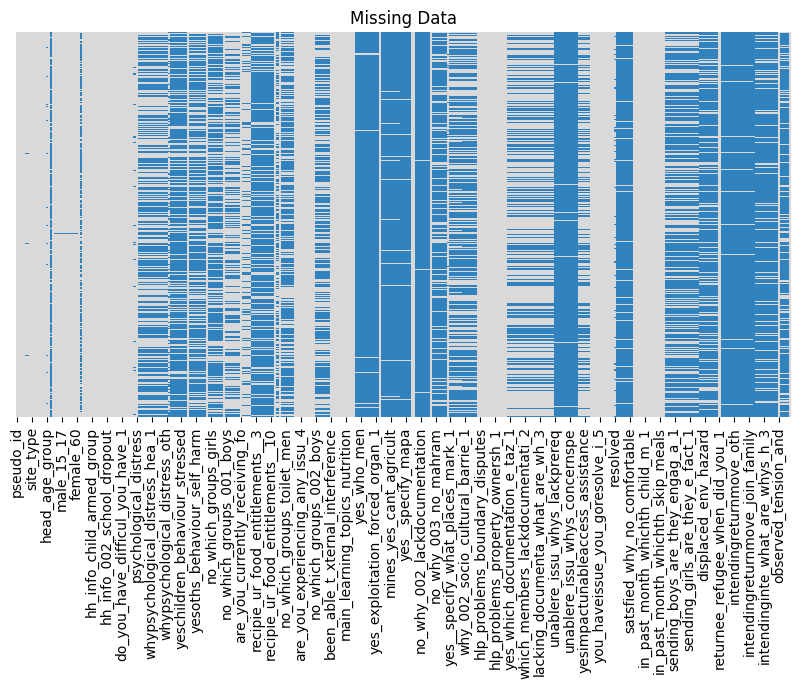

In [8]:
# Heatmap
sns.heatmap(train_data.isnull(),yticklabels = False, cbar = False,cmap = 'tab20c_r')
plt.title('Missing Data')
plt.show()

A lot of columns are full of missing data. But we can't drop most of this columns. This is because this missing data is a meaningful state.

For example, for the column whypsychological_distress_oth:

| Value   | Meaning                                      | Cases    |
| ------- | -------------------------------------------- | -------- |
| 1       | 0 (No)                                       | 4341     |
| 2       | 1 (Yes)                                      | 179      |
| Missing | *(Not asked / Not applicable / No distress)* | **4437** |

In surveys like this:
Missing often means “the question did not apply to the respondent.”

So we can't just drop this kind of columns because we would lose important values.


Besides this, there are some columns that are not useful for model trining. They don't provide any interesting information for us.
- id
- today
- interviewtype
- monitor_gender
- interview_province
- interview_district
- site_001
- assessment_modality

# Categorical Features

In [9]:
print('Non-Null Objects to Be Converted to Category')
print(train_data.select_dtypes(['object']).columns)

Non-Null Objects to Be Converted to Category
Index(['today', 'interviewtype', 'monitor_gender', 'interview_province',
       'interview_district', 'site_001', 'site_type', 'assessment_modality',
       'are_you_headhh', 'respondent_gender', 'status', 'province', 'district',
       'head_age_group', 'marital_status', 'widow_o_martyrdom_certi_cate',
       'what_is_your_occupation_what_i', 'what_is_sizeyour_famil',
       'have_children', 'have_children_001', 'do_you_have_difficul_you_have_1',
       'do_you_have_difficul_using_a__1', 'do_you_have_difficul_ngclimbi_1',
       'do_you_have_difficul_ingconce_1', 'do_you_have_difficul_all_verd_1',
       'using_your_usual_cubeing_unde_1', 'do_you_your_family_m_rotectio_1',
       'psychological_distress', 'children_behaviour', 'oth_members_behaviour',
       'health_facility', 'access_health_facility_no', 'psychological_support',
       'access_mhpss_facility_no_001', 'are_you_currently_receiving_fo',
       'wash_access', 'access_water', '

# Searching relations between different parameters

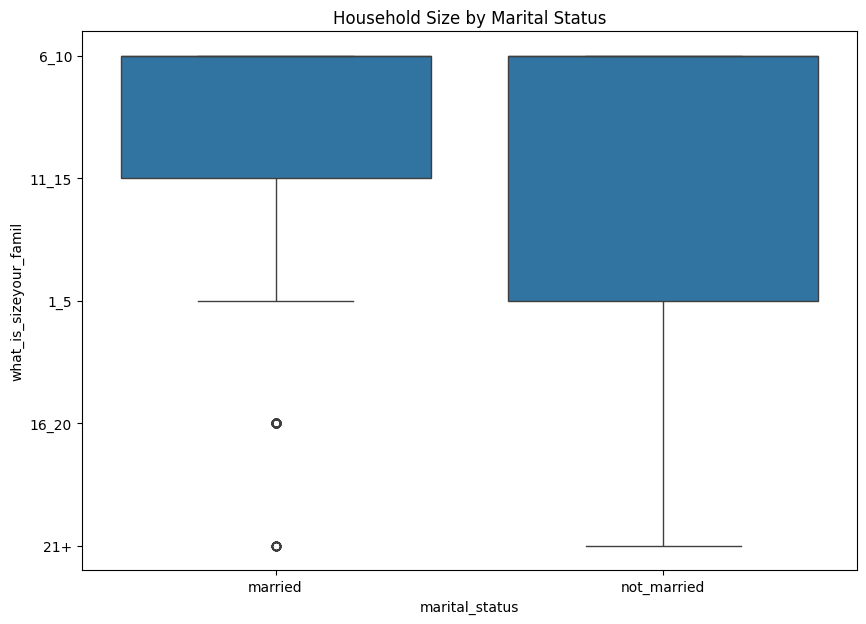

In [10]:
plt.figure(figsize=(10,7))
sns.boxplot(
    x='marital_status',
    y='what_is_sizeyour_famil',
    data=train_data
).set_title('Household Size by Marital Status')
plt.show()

While both married and non-married households commonly range between 6–15 members, extremely large households (21+ members) are observed more frequently among non-married household heads. This suggests extended or dependency-heavy household structures, likely driven by displacement, widowhood, or family aggregation as a coping strategy. These households may require differentiated shelter and support approaches.

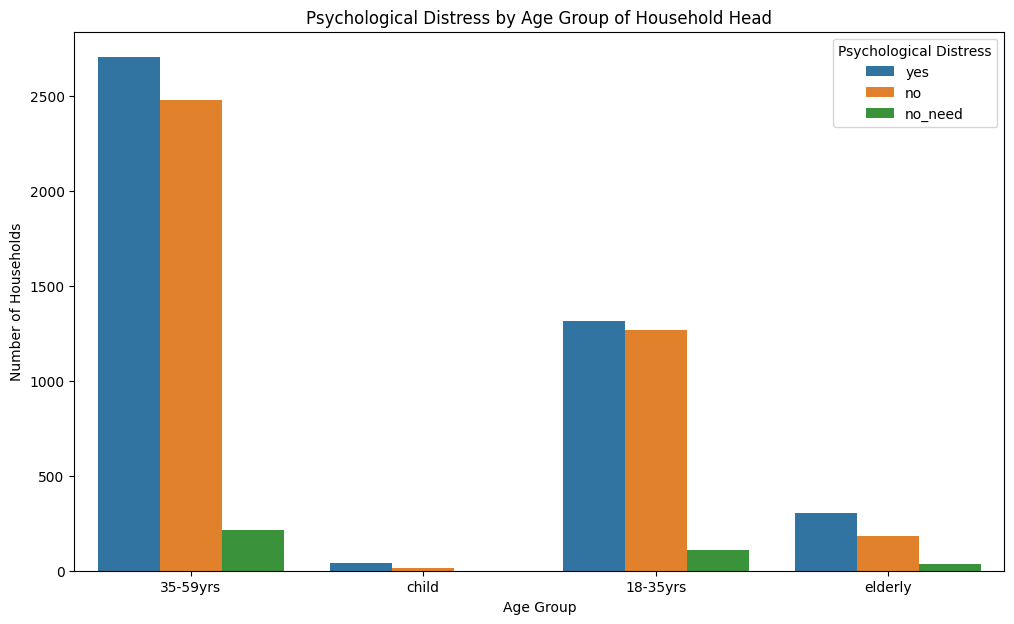

In [11]:
plt.figure(figsize=(12,7))
sns.countplot(
    x='head_age_group',
    hue='psychological_distress',
    data=train_data
)
plt.title('Psychological Distress by Age Group of Household Head')
plt.xlabel('Age Group')
plt.ylabel('Number of Households')
plt.legend(title='Psychological Distress')
plt.show()

Most people report needing psychological support, regardless of age.
Psychological distress is high across all age groups, and no specific age group stands out as having a significantly higher or lower level of distress.

In [12]:
plt.figure(figsize=(120,70))
sns.countplot(
    x='access_health_facility_no',
    hue='psychological_distress',
    data=train_data
)
plt.title('Psychological Distress by Access of health facilities')
plt.xlabel('Access of health facilities')
plt.ylabel('Psychological distress')
plt.legend(title='Psychological Distress')
plt.show()


The majority of people needs psychological help but does not have access to health facilities or the service is just not available.

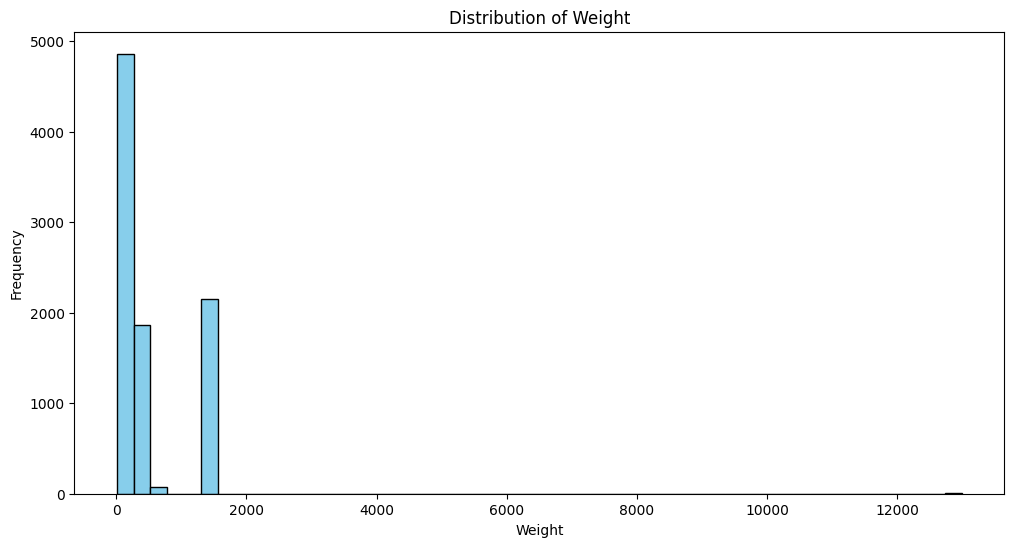

In [13]:
plt.figure(figsize=(12,6))
plt.hist(train_data['weight'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

Some weight values seem inconsistent, likely because different units of measurement were used.
This is very inconsistent, and we don't have any way to predict what the correct values would be, so we are going to drop the column.

# Preprocessing

### **Categorical Features**

In [14]:
# drop unnecessary columns
train_data = train_data.drop(columns=[
    'pseudo_id', 
    'today', 
    'interviewtype', 
    'monitor_gender', 
    'interview_province', 
    'interview_district', 
    'site_001', 
    'assessment_modality'
])

In [15]:
# Identify categorical features
objects = train_data.select_dtypes(['object']).columns

# Convert categorical variables into 'dummy' or indicator variables
for object_ in objects:
    pd.get_dummies(train_data[object_], drop_first = True)

train_data = pd.get_dummies(train_data, drop_first=True)
train_data.head(1)

,male_0_6,male_7_14,male_15_17,male_18_59,male_60,female_0_6,female_7_14,female_15_17,female_18_59,female_60,hh_info_person_health,hh_info_legal_needs,hh_info_school_dropout,hh_info_unable_work,hh_info_child_armed_group,hh_info_family_unity,hh_info_drug_dependence,hh_info_none,hh_info_oth,hh_info_002_person_health,hh_info_002_legal_needs,hh_info_002_school_dropout,hh_info_002_unable_work,hh_info_002_child_armed_group,hh_info_002_family_unity,hh_info_002_drug_dependence,hh_info_002_none,hh_info_002_oth,whypsychological_distress_con_1,whypsychological_distress_com_1,whypsychological_distress_fam_1,whypsychological_distress_out_1,whypsychological_distress_den_1,whypsychological_distress_chi_1,whypsychological_distress_hea_1,whypsychological_distress_den_2,whypsychological_distress_abuse,whypsychological_distress_ear_1,whypsychological_distress_lac_1,whypsychological_distress_foo_1,whypsychological_distress_eco_1,whypsychological_distress_oth,yeschildren_behaviour_withdrawn,yeschildren_behaviour_violent_1,yeschildren_behaviour_eating__1,yeschildren_behaviour_self_harm,yeschildren_behaviour_sad,yeschildren_behaviour_stressed,yeschildren_behaviour_suicida_1,yeschildren_behaviour_oth,yesoths_behaviour_withdrawn,yesoths_behaviour_violent_agg_1,yesoths_behaviour_eating_diso_1,yesoths_behaviour_self_harm,yesoths_behaviour_sad,yesoths_behaviour_stressed,yesoths_behaviour_suicidal_te_1,yesoths_behaviour_oth,no_which_groups_boys,no_which_groups_girls,no_which_groups_men,no_which_groups_women,no_which_groups_elder,no_which_groups_disability,no_which_groups_001_boys,no_which_groups_001_girls,no_which_groups_001_men,no_which_groups_001_women,no_which_groups_001_elder,no_which_groups_001_disability,you_are_not_a_ben_is_why_it_n_1,you_are_not_a_ben_is_why_it_n_2,you_are_not_a_ben_is_why_it_n_3,you_are_not_a_ben_is_why_it_n_4,recipie_ur_food_entitlements__1,recipie_ur_food_entitlements__2,recipie_ur_food_entitlements__3,recipie_ur_food_entitlements__4,recipie_ur_food_entitlements__5,recipie_ur_food_entitlements__6,recipie_ur_food_entitlements__7,recipie_ur_food_entitlements__8,recipie_ur_food_entitlements__9,recipie_ur_food_entitlements__10,recipie_ur_food_entitlements_oth,no_which_groups_toilet_boys,no_which_groups_toilet_girls,no_which_groups_toilet_men,no_which_groups_toilet_women,no_which_groups_toilet_elder,no_which_groups_toilet_disabi_1,are_you_experiencing_any_issu_1,are_you_experiencing_any_issu_2,are_you_experiencing_any_issu_3,are_you_experiencing_any_issu_4,are_you_experiencing_any_issu_5,are_you_experiencing_any_issu_6,are_you_experiencing_any_issu_7,are_you_experiencing_any_issu_8,are_you_experiencing_any_issu_9,no_which_groups_002_boys,no_which_groups_002_girls,no_which_groups_002_men,no_which_groups_002_women,no_which_groups_002_elder,no_which_groups_002_disability,main_learning_topics_access,main_learning_topics_housing,main_learning_topics_complaint,main_learning_topics_document_1,main_learning_topics_cash,main_learning_topics_disability,main_learning_topics_nutrition,main_learning_topics_agriculture,main_learning_topics_eligibility,main_learning_topics_oth,yes_who_boys,yes_who_girls,yes_who_men,yes_who_women,yes_exploitation_labour,yes_exploitation_sexual,yes_exploitation_forced_criminal,yes_exploitation_domestic,yes_exploitation_forced_drug,yes_exploitation_forced_organ_1,mines_yes_children_play,mines_yes_children_school,mines_yes_cant_access_services,mines_yes_cant_colect_water,mines_yes_cant_agricult,mines_yes_cant_graze_animals,mines_yes_oth,no_why_002_discr_exmahr,no_why_002_no_mahram,no_why_002_lackdocumentation,no_why_002_fear_personal_safety,no_why_002_safety_concerns_re_1,no_why_002_presenceexplosive__1,no_why_002_oth,no_why_003_discr_exmahr,no_why_003_no_mahram,no_why_003_lackdocumentation,no_why_003_fear_personal_safety,no_why_003_safety_concerns_re_1,no_why_003_presenceexplosive__1,no_why_003_oth,yes__specify_what_places_mark_1,yes__specify_what_places_wate_1,yes__specify_what_places_scho_1,yes__specify_what_places

In [16]:
# These columns must be 0 if they are not answered
count_cols = [
    'male_0_6','male_7_14','male_15_17','male_18_59','male_60',
    'female_0_6','female_7_14','female_15_17','female_18_59','female_60'
]
train_data[count_cols] = train_data[count_cols].fillna(0)

# NaN to 0
float_cols = train_data.select_dtypes(include='float64').columns
train_data[float_cols] = train_data[float_cols].fillna(0.0)

In [17]:
train_data = train_data.drop(columns=['weight'])
# Weight values are so inconsistent. They use different units so we can not use them.

We will interpret NaN values as unanswered responses. This approach gives more emphasis to positive answers.

In [18]:
train_data.head()

,male_0_6,male_7_14,male_15_17,male_18_59,male_60,female_0_6,female_7_14,female_15_17,female_18_59,female_60,hh_info_person_health,hh_info_legal_needs,hh_info_school_dropout,hh_info_unable_work,hh_info_child_armed_group,hh_info_family_unity,hh_info_drug_dependence,hh_info_none,hh_info_oth,hh_info_002_person_health,hh_info_002_legal_needs,hh_info_002_school_dropout,hh_info_002_unable_work,hh_info_002_child_armed_group,hh_info_002_family_unity,hh_info_002_drug_dependence,hh_info_002_none,hh_info_002_oth,whypsychological_distress_con_1,whypsychological_distress_com_1,whypsychological_distress_fam_1,whypsychological_distress_out_1,whypsychological_distress_den_1,whypsychological_distress_chi_1,whypsychological_distress_hea_1,whypsychological_distress_den_2,whypsychological_distress_abuse,whypsychological_distress_ear_1,whypsychological_distress_lac_1,whypsychological_distress_foo_1,whypsychological_distress_eco_1,whypsychological_distress_oth,yeschildren_behaviour_withdrawn,yeschildren_behaviour_violent_1,yeschildren_behaviour_eating__1,yeschildren_behaviour_self_harm,yeschildren_behaviour_sad,yeschildren_behaviour_stressed,yeschildren_behaviour_suicida_1,yeschildren_behaviour_oth,yesoths_behaviour_withdrawn,yesoths_behaviour_violent_agg_1,yesoths_behaviour_eating_diso_1,yesoths_behaviour_self_harm,yesoths_behaviour_sad,yesoths_behaviour_stressed,yesoths_behaviour_suicidal_te_1,yesoths_behaviour_oth,no_which_groups_boys,no_which_groups_girls,no_which_groups_men,no_which_groups_women,no_which_groups_elder,no_which_groups_disability,no_which_groups_001_boys,no_which_groups_001_girls,no_which_groups_001_men,no_which_groups_001_women,no_which_groups_001_elder,no_which_groups_001_disability,you_are_not_a_ben_is_why_it_n_1,you_are_not_a_ben_is_why_it_n_2,you_are_not_a_ben_is_why_it_n_3,you_are_not_a_ben_is_why_it_n_4,recipie_ur_food_entitlements__1,recipie_ur_food_entitlements__2,recipie_ur_food_entitlements__3,recipie_ur_food_entitlements__4,recipie_ur_food_entitlements__5,recipie_ur_food_entitlements__6,recipie_ur_food_entitlements__7,recipie_ur_food_entitlements__8,recipie_ur_food_entitlements__9,recipie_ur_food_entitlements__10,recipie_ur_food_entitlements_oth,no_which_groups_toilet_boys,no_which_groups_toilet_girls,no_which_groups_toilet_men,no_which_groups_toilet_women,no_which_groups_toilet_elder,no_which_groups_toilet_disabi_1,are_you_experiencing_any_issu_1,are_you_experiencing_any_issu_2,are_you_experiencing_any_issu_3,are_you_experiencing_any_issu_4,are_you_experiencing_any_issu_5,are_you_experiencing_any_issu_6,are_you_experiencing_any_issu_7,are_you_experiencing_any_issu_8,are_you_experiencing_any_issu_9,no_which_groups_002_boys,no_which_groups_002_girls,no_which_groups_002_men,no_which_groups_002_women,no_which_groups_002_elder,no_which_groups_002_disability,main_learning_topics_access,main_learning_topics_housing,main_learning_topics_complaint,main_learning_topics_document_1,main_learning_topics_cash,main_learning_topics_disability,main_learning_topics_nutrition,main_learning_topics_agriculture,main_learning_topics_eligibility,main_learning_topics_oth,yes_who_boys,yes_who_girls,yes_who_men,yes_who_women,yes_exploitation_labour,yes_exploitation_sexual,yes_exploitation_forced_criminal,yes_exploitation_domestic,yes_exploitation_forced_drug,yes_exploitation_forced_organ_1,mines_yes_children_play,mines_yes_children_school,mines_yes_cant_access_services,mines_yes_cant_colect_water,mines_yes_cant_agricult,mines_yes_cant_graze_animals,mines_yes_oth,no_why_002_discr_exmahr,no_why_002_no_mahram,no_why_002_lackdocumentation,no_why_002_fear_personal_safety,no_why_002_safety_concerns_re_1,no_why_002_presenceexplosive__1,no_why_002_oth,no_why_003_discr_exmahr,no_why_003_no_mahram,no_why_003_lackdocumentation,no_why_003_fear_personal_safety,no_why_003_safety_concerns_re_1,no_why_003_presenceexplosive__1,no_why_003_oth,yes__specify_what_places_mark_1,yes__specify_what_places_wate_1,yes__specify_what_places_scho_1,yes__specify_what_places

>Now the data is perfect for a machine learning algorithm:  
- all the data is numeric
- everything is concatenated together

## **MACHINE LEARNING**
Next, we will feed these features into various algorithms to determine the best performance using a simple framework.

- K Means
- Hierarchical
- DBSCAN
- HDBSCAN
- GMM (Gaussian Mixture Models)

First, we will split the data: 75% for training and 25% for testing.

In [19]:
from sklearn.model_selection import train_test_split

# Split data
train_df, test_df = train_test_split(train_data, test_size=0.25, random_state=42)
train_df.to_csv('../data/train_data.csv', index=False)
test_df.to_csv('../data/test_data.csv', index=False)

### Scaled parameters
We use scaled data (X_scaled) for model training because most machine learning algorithms rely on distance calculations.

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_df)

### Umap
We use UMAP only for visualization purposes, not for model training.

In [21]:
import umap

try:
    reducer = umap.UMAP(n_components=2,
                       n_neighbors=30,
                       min_dist=0.1,
                       metric='euclidean',
                       random_state=42,
                       verbose=True)
    embedding = reducer.fit_transform(X_scaled)
    train_df['umap1'] = embedding[:, 0]
    train_df['umap2'] = embedding[:, 1]
except Exception as e:
    print("Couldn't use Umap 2D:", e)
    embedding = X_scaled[:, :2]
    train_df['umap1'] = embedding[:, 0]
    train_df['umap2'] = embedding[:, 1]

X_umap = embedding

UMAP(n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Thu Jan 15 18:06:12 2026 Construct fuzzy simplicial set
Thu Jan 15 18:06:12 2026 Finding Nearest Neighbors
Thu Jan 15 18:06:12 2026 Building RP forest with 9 trees
Thu Jan 15 18:06:17 2026 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Thu Jan 15 18:06:28 2026 Finished Nearest Neighbor Search
Thu Jan 15 18:06:30 2026 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jan 15 18:07:10 2026 Finished embedding


# K Means

In [22]:
dfkmean = train_df

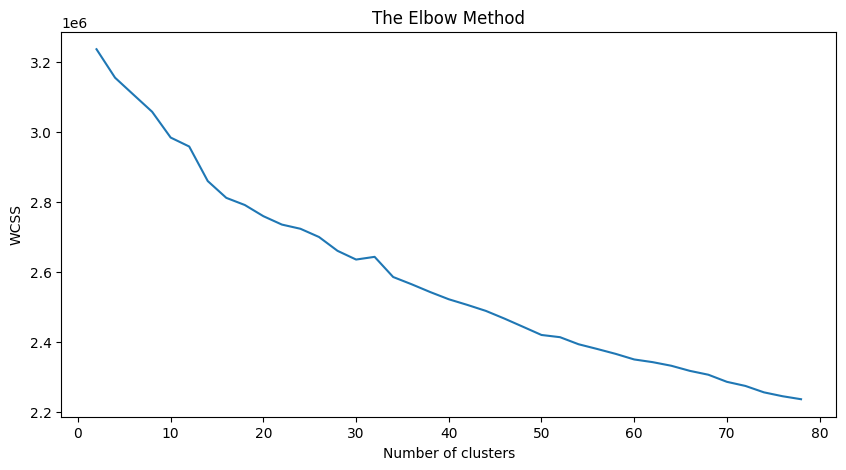

In [46]:
from sklearn.cluster import KMeans
wcss = []
for i in range(2, 80, 2):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 80, 2), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [47]:
n_clusters = 35

Using the elbow method, we analyze how the within-cluster sum of squares (WCSS) changes as the number of clusters increases in the KMeans model. 

At first, adding clusters significantly reduces WCSS, but after a certain point the improvement becomes marginal. The optimal number of clusters is identified where this reduction starts to slow down noticeably, forming an “elbow” in the curve. 

In our case, the ideal number of clusters would be around 30 and 40. So we will use 22 clusters for and example. 

In [48]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

In [49]:
dfkmean['cluster'] = y_kmeans

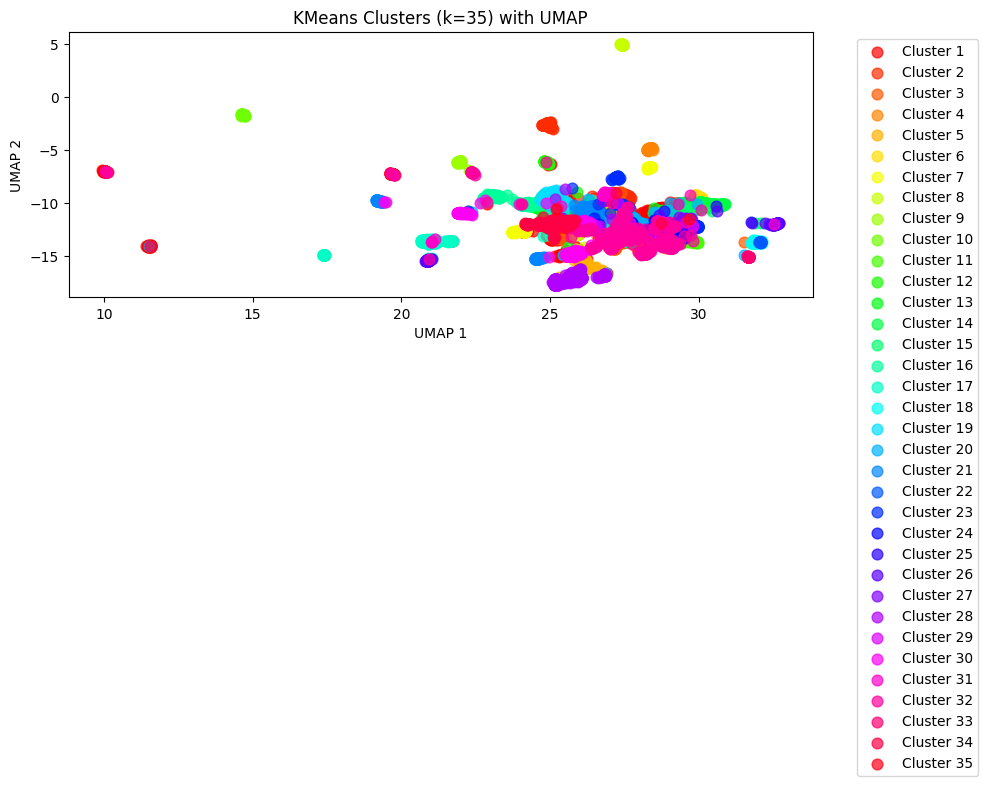

In [50]:
plt.figure(figsize=(10, 6))

cmap = plt.cm.get_cmap('hsv', n_clusters)

for i in range(n_clusters):
    mask = y_kmeans == i

    plt.scatter(
        train_df.loc[mask, 'umap1'],
        train_df.loc[mask, 'umap2'],
        s=60,
        alpha=0.7,
        color=cmap(i),
        label=f'Cluster {i + 1}'
    )

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(f'KMeans Clusters (k={n_clusters}) with UMAP')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


KMeans is not suitable for this project because it assumes clusters are spherical and of similar size, and it relies on minimizing variance around cluster centers. Our data likely has irregularly shaped clusters with varying densities, which KMeans cannot capture accurately. Methods like HDBSCAN are better for detecting non-uniform, dense regions, giving a more realistic clustering.

# Hierarchical

In [28]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
dfhierarchical = train_df

In [29]:
for k in [2, 4, 6, 8, 10, 20, 30, 34]:
    labels = AgglomerativeClustering(k, linkage='ward').fit_predict(X_scaled)
    print(
        k,
        calinski_harabasz_score(X_scaled, labels),
        davies_bouldin_score(X_scaled, labels)
    )

2 123.25273675350167 6.537302286522032
4 107.41537762617816 4.562735549722992
6 98.43470981028098 4.451614829403785
8 92.26128033798673 4.270622167134017
10 87.37722236199562 3.9447747016436
20 67.7206750912158 3.778139119521454
30 58.06304863937499 3.600231652557781
34 55.447887833584645 3.4608933873132814


In [30]:
best_k = 4

Lower k values (like 2–4) give higher Calinski–Harabasz scores and higher Davies–Bouldin scores, but they are too coarse for a dataset with 389 features, capturing only broad structures.

In [31]:
from sklearn.cluster import AgglomerativeClustering
hierarchical = AgglomerativeClustering(
    n_clusters=best_k,
    linkage='ward'
)

hierarchical_labels = hierarchical.fit_predict(X_scaled)

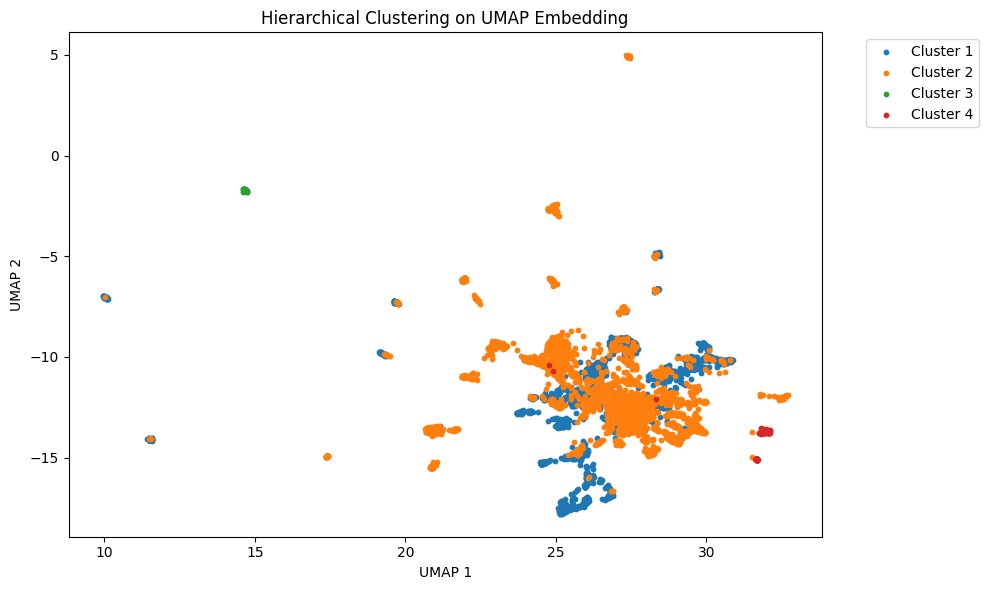

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Colormap
n_clusters = len(np.unique(hierarchical_labels))
cmap = plt.cm.get_cmap('tab20', n_clusters)

for i in range(n_clusters):
    mask = hierarchical_labels == i
    plt.scatter(
        train_df.loc[mask, 'umap1'],
        train_df.loc[mask, 'umap2'],
        s=10,
        label=f'Cluster {i + 1}'
    )

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title("Hierarchical Clustering on UMAP Embedding")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Although the clustering evaluation indicates that 4 clusters provide the best statistical separation, this result mainly captures the global structure of the data and is too coarse for the objectives of this project. 

Our goal is to identify more detailed population groups in order to better support the selection and design of suitable shelters. 

Therefore, we will explore and compare different clustering models to determine whether alternative approaches can provide more useful and actionable groupings for this purpose.

# DBSCAN

In [33]:
dfdbscan = train_df

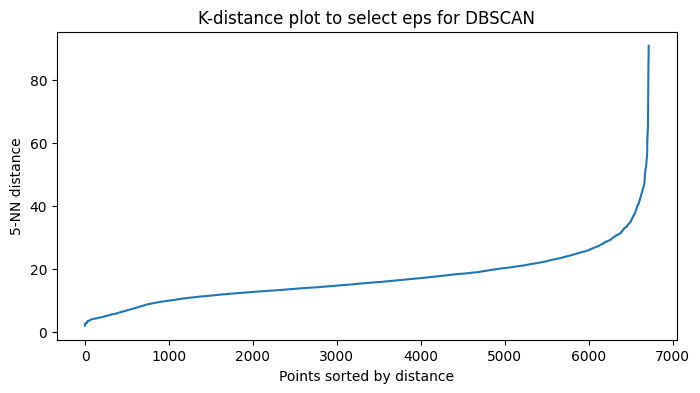

In [34]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

k_distances = np.sort(distances[:, -1])
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.ylabel(f"{min_samples}-NN distance")
plt.xlabel("Points sorted by distance")
plt.title("K-distance plot to select eps for DBSCAN")
plt.show()

The K-distance curve says that the best eps for this model (the elbow) is between 6 and 9.

In [69]:
from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(
    eps=7,
    min_samples=5
)

labels = dbscan_model.fit_predict(X_scaled)

In [70]:
from sklearn.metrics import davies_bouldin_score

dbi = davies_bouldin_score(X_scaled, labels)
print("DBI:", dbi)

DBI: 1.8200144529983504


The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score.

The minimum score is zero, with lower values indicating better clustering.

This 1.8 value is relativelly low. If we increase ther parameter eps, we get a bigger DBI. So this is a good approach for our model.

In [71]:
final_dbscan = DBSCAN(eps=7, min_samples=5)
final_labels = final_dbscan.fit_predict(X_scaled)

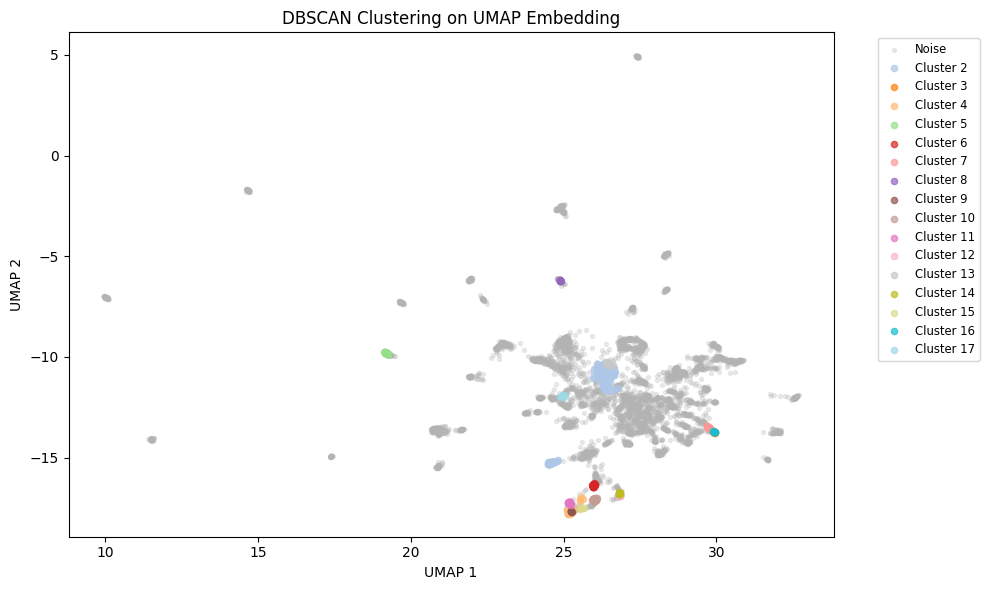

In [72]:
import matplotlib.pyplot as plt

cluster_ids = np.unique(final_labels)
cmap = plt.cm.get_cmap('tab20', len(cluster_ids))

plt.figure(figsize=(10, 6))
for idx, c in enumerate(cluster_ids):
    mask = final_labels == c
    color = (0.7, 0.7, 0.7) if c == -1 else cmap(idx)
    alpha = 0.25 if c == -1 else 0.7
    s = 8 if c == -1 else 20
    label = 'Noise' if c == -1 else f'Cluster {idx+1}'

    plt.scatter(
        train_df.loc[mask, 'umap1'],
        train_df.loc[mask, 'umap2'],
        color=color,
        alpha=alpha,
        s=s,
        label=label
    )

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title("DBSCAN Clustering on UMAP Embedding")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

The current DBSCAN configuration is appropriate because the eps parameter was selected using the k-distance plot, which means it reflects the true density structure of the data rather than being chosen arbitrarily. The resulting clusters are well separated in the UMAP space, and most low-density or anomalous points are correctly identified as noise. In addition, the Davies–Bouldin index is significantly improved, indicating that the clusters are compact and well differentiated.

Overall, this shows that DBSCAN is capturing the natural grouping of the data reasonably well.

However, we will also experiment with HDBSCAN, which is a more advanced density-based clustering method. Unlike DBSCAN, HDBSCAN can automatically adapt to clusters with varying densities and does not rely on a single fixed eps value. It generally produces more stable and robust clusters on UMAP embeddings, and often yields more natural and reliable segmentation results.

# HDBSCAN

In [39]:
import hdbscan

In [40]:
dfhdbscan = train_df

### Optimal configuration
Lets search whats the optimal configuration for our HDBSCAN model now

In [42]:
from itertools import product
from sklearn.metrics import silhouette_score
import hdbscan
import pandas as pd
import numpy as np

param_grid = {
    'min_cluster_size': [15, 20, 25, 30],
    'min_samples': [6, 7, 8, 9, 10, 20, 30]
}

results = []

for mcs, ms in product(param_grid['min_cluster_size'], param_grid['min_samples']):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
    labels = clusterer.fit_predict(X_scaled)
    
    mask = labels != -1
    unique_labels = np.unique(labels[mask])
    if unique_labels.size < 2:
        continue
    
    score = silhouette_score(X_scaled[mask], labels[mask])
    results.append({'min_cluster_size': mcs, 'min_samples': ms, 'silhouette': score})

results_df = pd.DataFrame(results)
if results_df.empty:
    print("No valid clustering found (need >=2 clusters excluding noise).")
    best_min_cluster_size = param_grid['min_cluster_size'][0]
    best_min_samples = param_grid['min_samples'][0]
else:
    results_df = results_df.sort_values('silhouette', ascending=False)
    print(results_df)
    best_min_cluster_size = int(results_df.iloc[0]['min_cluster_size'])
    best_min_samples = int(results_df.iloc[0]['min_samples'])

    min_cluster_size  min_samples  silhouette
26                30           20    0.365422
12                20           20    0.364987
19                25           20    0.364865
16                25            8    0.358214
15                25            7    0.356935
14                25            6    0.355998
21                30            6    0.355998
17                25            9    0.354414
18                25           10    0.352702
5                 15           20    0.350768
4                 15           10    0.319727
25                30           10    0.317779
3                 15            9    0.314725
11                20           10    0.312350
24                30            9    0.310088
10                20            9    0.307988
20                25           30    0.307675
27                30           30    0.307675
6                 15           30    0.307675
13                20           30    0.307675
23                30            8 

Best params are pulled from the grid search above (stored in `best_min_cluster_size` / `best_min_samples`).

In [43]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_samples)
labels = clusterer.fit_predict(X_scaled)

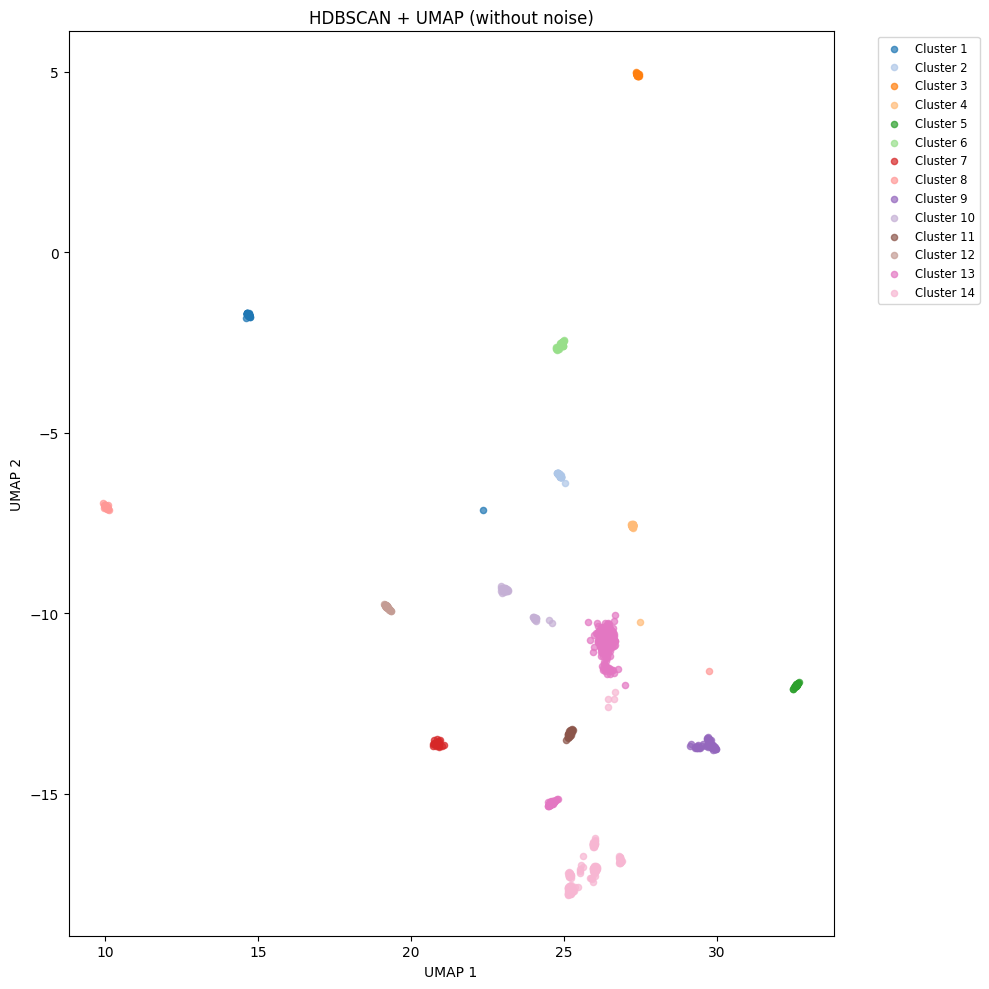

In [44]:
dfhdbscan['cluster'] = labels
plt.figure(figsize=(10, 10))

show_noise = False

cluster_ids = [c for c in np.unique(dfhdbscan['cluster']) if (c != -1 or show_noise)]

if show_noise and (-1 in np.unique(dfhdbscan['cluster'])):
    cluster_ids = sorted(np.unique(dfhdbscan['cluster']))
else:
    cluster_ids = [c for c in sorted(np.unique(dfhdbscan['cluster'])) if c != -1]

n_clusters = len([c for c in cluster_ids if c != -1])

if n_clusters == 0:
    print("No clusters found.")
else:
    cmap = plt.cm.get_cmap('tab20')
    cluster_map = {orig_id: i for i, orig_id in enumerate([c for c in cluster_ids if c != -1])}

    for orig_cluster in cluster_ids:
        mask = dfhdbscan['cluster'] == orig_cluster
        if orig_cluster == -1:
            color = (0.7, 0.7, 0.7)
            label = 'Noise'
            alpha = 0.25
            s = 8
        else:
            idx = cluster_map[orig_cluster]
            color = cmap(idx % 20)
            label = f'Cluster {idx + 1}'
            alpha = 0.7
            s = 20

        plt.scatter(dfhdbscan.loc[mask, 'umap1'], dfhdbscan.loc[mask, 'umap2'],
                    color=color, label=label, alpha=alpha, s=s)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('HDBSCAN + UMAP (without noise)' if not show_noise else 'cluster' + 'HDBSCAN + UMAP (with noise)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=30, random_state=0).fit_transform(X_scaled)
labels = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5).fit_predict(X_pca)

In [80]:
import hdbscan
import numpy as np
import pandas as pd

param_grid = {
    "min_cluster_size": [10],
    "min_samples": [None, 5]   # None = defaults to min_cluster_size
}

rows = []

for mcs in param_grid["min_cluster_size"]:
    for ms in param_grid["min_samples"]:
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=mcs,
            min_samples=ms,
            prediction_data=False
        )
        labels = clusterer.fit_predict(X_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters < 2:
            continue

        noise_ratio = np.mean(labels == -1)

        non_noise = labels != -1
        mean_conf = float(np.mean(clusterer.probabilities_[non_noise])) if np.any(non_noise) else 0.0
        mean_persist = float(np.mean(clusterer.cluster_persistence_)) if len(clusterer.cluster_persistence_) else 0.0

        # cluster size stats
        sizes = np.bincount(labels[non_noise])
        # careful: bincount uses label ids; easiest is:
        uniq, cnt = np.unique(labels[non_noise], return_counts=True)
        min_size = int(cnt.min())
        med_size = float(np.median(cnt))

        rows.append({
            "mcs": mcs,
            "ms": ms,
            "n_clusters": n_clusters,
            "noise": noise_ratio,
            "mean_conf": mean_conf,
            "mean_persistence": mean_persist,
            "min_cluster_size_found": min_size,
            "median_cluster_size": med_size
        })

df = pd.DataFrame(rows)

print("Total valid runs (>=2 clusters):", len(df))
print(df.sort_values(["noise","n_clusters"]).head(20))
print(df.describe(include="all"))

# Example filtering rules (tune these to your expectations)
df2 = df[
    (df["noise"].between(0.05, 0.45)) &      # not too little / too much noise
    (df["min_cluster_size_found"] >= 10) &   # avoid tiny clusters
    (df["n_clusters"].between(3, 30))        # avoid 1-2 clusters or 200 clusters
].copy()

# Rank: prefer stability + confidence, then reasonable noise
df2["score"] = (
    0.45 * df2["mean_persistence"] +
    0.45 * df2["mean_conf"] -
    0.10 * df2["noise"]
)

df2 = df2.sort_values("score", ascending=False)
print(df2.head(15))


Total valid runs (>=2 clusters): 2
   mcs   ms  n_clusters     noise  mean_conf  mean_persistence  \
1   10  5.0          63  0.653863   0.940396          0.035487   
0   10  NaN          43  0.749888   0.930720          0.045134   

   min_cluster_size_found  median_cluster_size  
1                      10                 20.0  
0                      10                 31.0  
        mcs   ms  n_clusters     noise  mean_conf  mean_persistence  \
count   2.0  1.0    2.000000  2.000000   2.000000          2.000000   
mean   10.0  5.0   53.000000  0.701876   0.935558          0.040310   
std     0.0  NaN   14.142136  0.067900   0.006842          0.006821   
min    10.0  5.0   43.000000  0.653863   0.930720          0.035487   
25%    10.0  5.0   48.000000  0.677870   0.933139          0.037899   
50%    10.0  5.0   53.000000  0.701876   0.935558          0.040310   
75%    10.0  5.0   58.000000  0.725882   0.937977          0.042722   
max    10.0  5.0   63.000000  0.749888   0.940396  

In [ ]:
import hdbscan
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# --- PCA to 50 dimensions (clustering space) ---
pca = PCA(n_components=50, random_state=0)
X_pca50 = pca.fit_transform(X_scaled)

print("X_scaled shape:", X_scaled.shape)
print("X_pca50 shape:", X_pca50.shape)
print("Explained variance (50 comps):", pca.explained_variance_ratio_.sum())

param_grid = {
    "min_cluster_size": [2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 10],
    "min_samples": [None, 2, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20]   # None = defaults to min_cluster_size (HDBSCAN default behavior)
}

rows = []

for mcs in param_grid["min_cluster_size"]:
    for ms in param_grid["min_samples"]:
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=mcs,
            min_samples=ms,
            prediction_data=False
        )
        labels = clusterer.fit_predict(X_pca50)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters < 2:
            continue

        noise_ratio = np.mean(labels == -1)

        non_noise = labels != -1
        mean_conf = float(np.mean(clusterer.probabilities_[non_noise])) if np.any(non_noise) else 0.0
        mean_persist = float(np.mean(clusterer.cluster_persistence_)) if len(clusterer.cluster_persistence_) else 0.0

        # cluster size stats (exclude noise)
        uniq, cnt = np.unique(labels[non_noise], return_counts=True)
        min_size = int(cnt.min())
        med_size = float(np.median(cnt))

        rows.append({
            "mcs": mcs,
            "ms": ms,
            "n_clusters": n_clusters,
            "noise": noise_ratio,
            "mean_conf": mean_conf,
            "mean_persistence": mean_persist,
            "min_cluster_size_found": min_size,
            "median_cluster_size": med_size
        })

df = pd.DataFrame(rows)

print("Total valid runs (>=2 clusters):", len(df))
if not df.empty:
    print(df.sort_values(["noise", "n_clusters"]).head(20))
    print(df.describe(include="all"))
else:
    print("No valid clusterings found (>=2 clusters excluding noise).")

# Example filtering rules (tune these to your expectations)
if not df.empty:
    df2 = df[
        (df["noise"].between(0.30, 0.70)) &
        (df["n_clusters"].between(10, 40)) &
        (df["min_cluster_size_found"] >= 20)
    ].copy()

    if df2.empty:
        print("\nNo configs passed the filter. Try relaxing thresholds (noise/n_clusters/min_cluster_size_found).")
    else:
        # Rank: prefer stability + confidence, then reasonable noise
        df2["score"] = (
            0.50 * df2["mean_persistence"] +
            0.40 * df2["mean_conf"] -
            0.30 * df2["noise"]
        )

        df2 = df2.sort_values("score", ascending=False)
        print(df2.head(15))


X_scaled shape: (6717, 500)
X_pca50 shape: (6717, 50)
Explained variance (50 comps): 0.4248345553967885
Total valid runs (>=2 clusters): 30
    mcs   ms  n_clusters     noise  mean_conf  mean_persistence  \
6     4  2.0         219  0.362215   0.937808          0.020802   
0     2  NaN         390  0.363555   0.949271          0.012460   
1     2  2.0         390  0.363555   0.949271          0.012460   
11    8  2.0         118  0.364002   0.925224          0.021682   
16   10  2.0         103  0.386482   0.920918          0.025735   
7     4  3.0         179  0.409707   0.920299          0.020324   
12    8  3.0         107  0.413726   0.918663          0.022176   
21   20  2.0          61  0.419681   0.915095          0.057459   
17   10  3.0          92  0.426679   0.919195          0.023431   
5     4  NaN         136  0.427721   0.910088          0.019031   
2     2  3.0         256  0.428912   0.930951          0.015780   
8     4  5.0         125  0.453327   0.911345          0

In [85]:
best = df2.iloc[0]
best_mcs = int(best["mcs"])
best_ms = None if pd.isna(best["ms"]) else int(best["ms"])

clusterer = hdbscan.HDBSCAN(min_cluster_size=best_mcs, min_samples=best_ms)
labels = clusterer.fit_predict(X_pca50)   # IMPORTANT: mismo espacio que evaluaste

In [88]:
print("best mcs: " + str(best['mcs']))
print("best ms: " + str(best['ms']))

best mcs: 30.0
best ms: 5.0


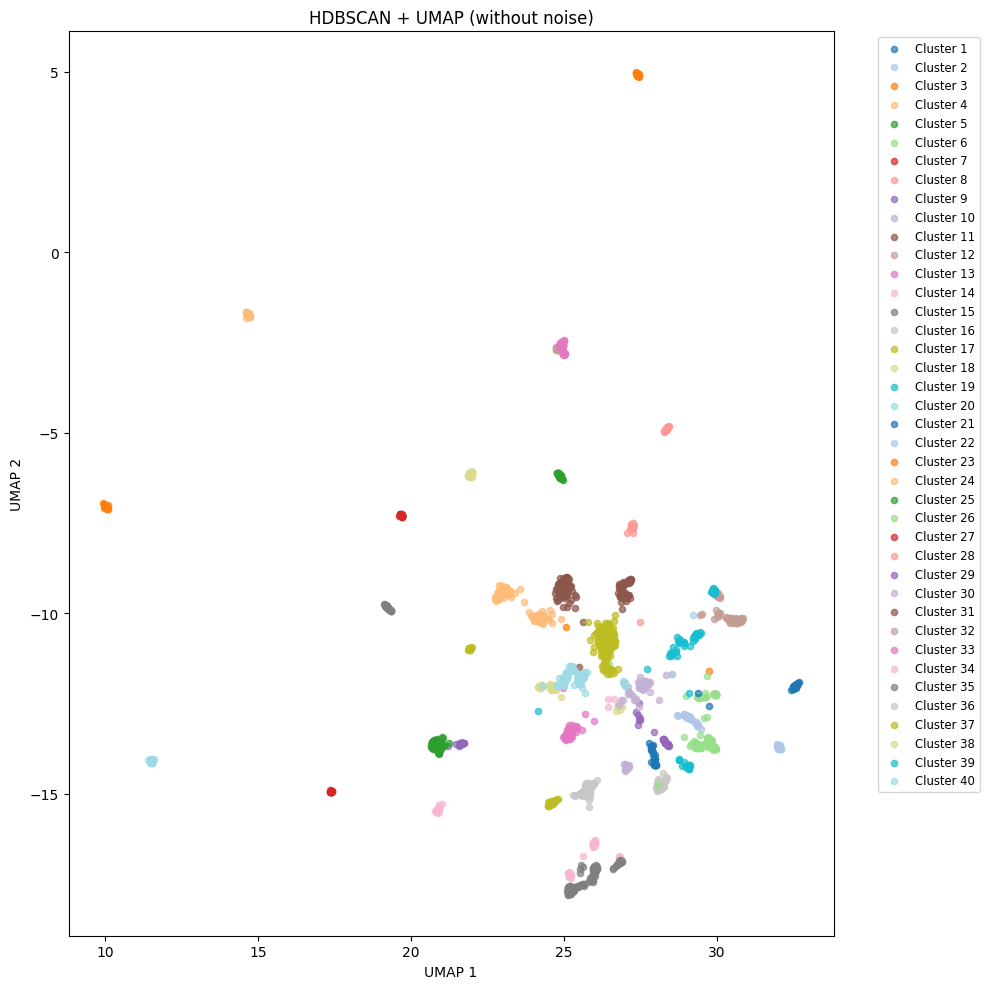

In [86]:
dfhdbscan['cluster'] = labels
plt.figure(figsize=(10, 10))

show_noise = False

cluster_ids = [c for c in np.unique(dfhdbscan['cluster']) if (c != -1 or show_noise)]

if show_noise and (-1 in np.unique(dfhdbscan['cluster'])):
    cluster_ids = sorted(np.unique(dfhdbscan['cluster']))
else:
    cluster_ids = [c for c in sorted(np.unique(dfhdbscan['cluster'])) if c != -1]

n_clusters = len([c for c in cluster_ids if c != -1])

if n_clusters == 0:
    print("No clusters found.")
else:
    cmap = plt.cm.get_cmap('tab20')
    cluster_map = {orig_id: i for i, orig_id in enumerate([c for c in cluster_ids if c != -1])}

    for orig_cluster in cluster_ids:
        mask = dfhdbscan['cluster'] == orig_cluster
        if orig_cluster == -1:
            color = (0.7, 0.7, 0.7)
            label = 'Noise'
            alpha = 0.25
            s = 8
        else:
            idx = cluster_map[orig_cluster]
            color = cmap(idx % 20)
            label = f'Cluster {idx + 1}'
            alpha = 0.7
            s = 20

        plt.scatter(dfhdbscan.loc[mask, 'umap1'], dfhdbscan.loc[mask, 'umap2'],
                    color=color, label=label, alpha=alpha, s=s)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('HDBSCAN + UMAP (without noise)' if not show_noise else 'cluster' + 'HDBSCAN + UMAP (with noise)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()